In [4]:
# -*- coding: utf-8 -*-
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import AveragePooling2D
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers import Dense
import keras
import keras_metrics
import numpy as np
import requests
import cv2
import os

def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream = True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()

def downloadFiles():
    
    urlsDownload = [
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/MnistKeras.npz',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-one.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-two.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-three.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-four.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-five.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-six.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-seven.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-eight.png',
            'https://github.com/AlfredoFilho/Auto-Correction-Tests/raw/master/filesDownload/myNumbers/number-nine.png'
            ]
    
    print('\nDownload files...')
    
    if((os.path.isdir("files")) == False):
        os.mkdir('files')
    
    os.chdir('files')
        
    for url in urlsDownload:
        nameFile = url.split('/')[-1]
        if (os.path.exists(nameFile) == False):
            download_file(url)
    
    os.chdir("..")
    
    print('...Finish download\n')

def load_data(path):

    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

        x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
        x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

        x_train = x_train / 255
        x_test = x_test / 255

        y_train = np_utils.to_categorical(y_train)
        y_test = np_utils.to_categorical(y_test)

    return x_train, y_train, x_test, y_test

downloadFiles()
np.random.seed(2019)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
x_train, y_train, x_test, y_test = load_data('files/MnistKeras.npz')

class Model:
    def __init__(self):
        self.model = self.getModel()

    def defineTrain(self, name, epochs, batch_size, nameCallback, patienceCallback):
        self.name = name
        self.epochs = epochs
        self.batch_size = batch_size
        self.nameCallback = nameCallback
        self.patienceCallback = patienceCallback
        
    def get_callbacks(self, name, patience_lr):
        mcp_save = ModelCheckpoint(name + '.h5', save_best_only = True,
                                         monitor = 'val_accuracy', mode='max')
        reduce_lr_loss = ReduceLROnPlateau(monitor = 'loss', factor = 0.1,
                                           patience = patience_lr,
                                           verbose = 1, min_delta = 1e-4,
                                           mode = 'min')
        early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 10,
                                   verbose = 0, mode = 'max', baseline = None)
        csv_logger = CSVLogger(name + '_log.csv', append = True, separator = ';')
        return [reduce_lr_loss, early_stop, csv_logger, mcp_save]
    
    def loadModel(self, nameLoad):
        self.model.load_weights(nameLoad)
        
    def trainModel(self):
        self.model.summary()
                
        self.model.fit(x_train, y_train, validation_data = (x_test, y_test),
                  epochs = self.epochs, batch_size = self.batch_size,
                  callbacks = self.get_callbacks(self.nameCallback, self.patienceCallback))
        
        self.model.save_weights(self.name)
        
    def printAcc(self):
        scores = self.model.evaluate(x_test, y_test, verbose = 0)
        print("\nAcc: %.2f%%" % (scores[1]*100))
    
    def testModel(self):
        images = ['files/number-one.png', 'files/number-two.png', 'files/number-three.png', 'files/number-four.png', 'files/number-five.png',
              'files/number-six.png', 'files/number-seven.png', 'files/number-eight.png', 'files/number-nine.png'
              ]

        for image in images:
            img_pred = cv2.imread(image, 0)
            plt.imshow(img_pred, cmap='gray')
    
            if img_pred.shape != [28,28]:
                img2 = cv2.resize(img_pred, (28, 28))
                img_pred = img2.reshape(28, 28, -1)
            else:
                img_pred = img_pred.reshape(28, 28, -1)
    
            img_pred = ~img_pred
            img_pred = img_pred.reshape(1, 28, 28, 1).astype('float32')

            img_pred = img_pred/255.0
    
            pred = self.model.predict_classes(img_pred)
            pred_proba = self.model.predict_proba(img_pred)
            pred_proba = "%.2f%%" % (pred_proba[0][pred]*100)
            print(pred[0], " com confiança de ", pred_proba)
            plt.show()
        
    def getModel(self):

        num_classes = 10
        optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)
        model = Sequential()

        model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1), activation = 'relu', padding = 'same'))
        model.add(AveragePooling2D(pool_size = (2, 2), strides = 2))
        model.add(Dropout(0.2))

        model.add(BatchNormalization())

        model.add(Conv2D(64, (3, 3), input_shape = (28, 28, 1), activation = 'relu', padding = 'same'))
        model.add(AveragePooling2D(pool_size = (2, 2), strides = 2))
        model.add(Dropout(0.2))

        model.add(BatchNormalization())
    
        model.add(Conv2D(128, (3, 3), input_shape = (28, 28, 1), activation = 'relu', padding = 'same'))
        model.add(AveragePooling2D(pool_size = (2, 2), strides = 2))
        model.add(Dropout(0.3))

        model.add(BatchNormalization())            
        model.add(GlobalMaxPooling2D())
        
        model.add(Dense(256, activation = 'relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation = 'softmax', name = 'predict'))
    
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy', keras_metrics.precision(), keras_metrics.recall()])
    
        return model


Download files...
...Finish download



tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14

Epoch 24/1000
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0255 - accuracy: 0.9921 - precision: 0.9946 - recall: 0.9945 - val_loss: 0.0151 - val_accuracy: 0.9946 - val_precision: 0.9897 - val_recall: 0.9996
Epoch 25/1000
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0256 - accuracy: 0.9921 - precision: 0.9930 - recall: 0.9936 - val_loss: 0.0171 - val_accuracy: 0.9940 - val_precision: 0.9927 - val_recall: 0.9981
Epoch 26/1000
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0256 - accuracy: 0.9923 - precision: 0.9936 - recall: 0.9932 - val_loss: 0.0154 - val_accuracy: 0.9950 - val_precision: 0.9915 - val_recall: 1.0000
Epoch 27/1000
60000/60000 [==============================] - 59s 979us/step - loss: 0.0242 - accuracy: 0.9921 - precision: 0.9966 - recall: 0.9957 - val_loss: 0.0165 - val_accuracy: 0.9942 - val_precision: 0.9942 - val_recall: 0.9980
Epoch 28/1000
60000/60000 [==============================] - 61s 1ms/s

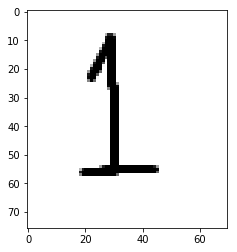

2  com confiança de  100.00%


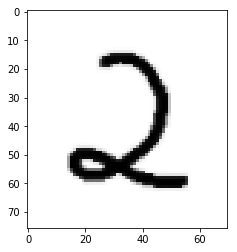

3  com confiança de  100.00%


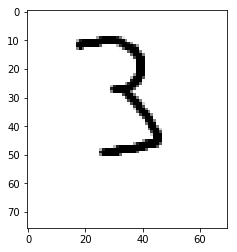

4  com confiança de  100.00%


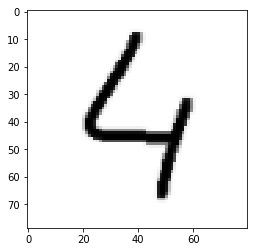

5  com confiança de  100.00%


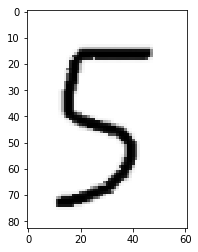

6  com confiança de  99.24%


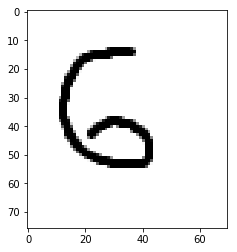

7  com confiança de  89.22%


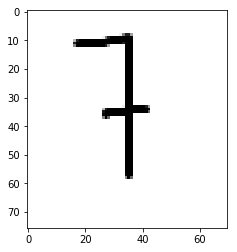

8  com confiança de  100.00%


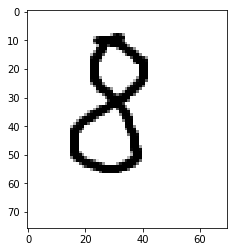

9  com confiança de  99.47%


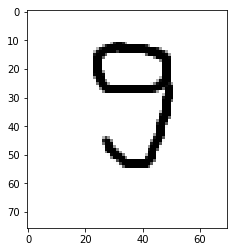


Acc: 99.56%


In [5]:

brain = Model()
#brain.loadModel('BrainRMSPropMin.h5')
brain.defineTrain(name = 'Brain.h5', epochs = 1000, batch_size = 128, nameCallback = 'BrainCB', patienceCallback = 10)
brain.trainModel()
brain.testModel()
brain.printAcc()